# Person Detection using YOLO11

This notebook demonstrates person detection using Ultralytics YOLO11.

**Objectives:**
- Detect and locate all persons in images/video frames
- Filter detections to only the "person" class
- Visualize bounding boxes with confidence scores
- Process both images and videos

**Model:** YOLO11s (small variant - optimized for CPU)

## 1. Setup & Installation

In [ ]:
# Install required packages (run once)
# !pip install ultralytics opencv-python matplotlib pandas tqdm

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json

from ultralytics import YOLO

# Set up paths
PROJECT_ROOT = Path("../")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "detections"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load YOLO11s model (will download automatically on first run)
model = YOLO("yolo11s.pt")

# Print model info
print(f"Model: {model.model_name}")
print(f"Task: {model.task}")
print(f"\nClass names (showing first 10):")
for i, name in list(model.names.items())[:10]:
    print(f"  {i}: {name}")
print(f"\nPerson class ID: 0")

Model: yolo11s.pt
Task: detect

Class names (showing first 10):
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light

Person class ID: 0


## 2. Download Sample Images

In [3]:
# Download sample images for testing
import urllib.request

sample_images = {
    "bus.jpg": "https://ultralytics.com/images/bus.jpg",
    "zidane.jpg": "https://ultralytics.com/images/zidane.jpg"
}

images_dir = DATA_DIR / "images"
images_dir.mkdir(parents=True, exist_ok=True)

for filename, url in sample_images.items():
    filepath = images_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
        print(f"  Saved to {filepath}")
    else:
        print(f"{filename} already exists")

print("\nSample images ready!")

  Saved to ../data/images/bus.jpg
  Saved to ../data/images/zidane.jpg

Sample images ready!


## 3. Single Image Detection

In [4]:
def detect_persons(image_path, model, conf_threshold=0.25, save_path=None):
    """
    Detect persons in an image using YOLO11.
    
    Args:
        image_path: Path to input image
        model: YOLO model instance
        conf_threshold: Confidence threshold (0-1)
        save_path: Optional path to save annotated image
    
    Returns:
        results: Detection results
        detections: List of detection dictionaries
    """
    # Run detection (class 0 = person in COCO)
    results = model.predict(
        source=image_path,
        classes=[0],  # Only detect persons
        conf=conf_threshold,
        verbose=False
    )
    
    # Extract detection information
    detections = []
    for result in results:
        boxes = result.boxes
        for i, box in enumerate(boxes):
            detection = {
                "id": i,
                "class": "person",
                "confidence": float(box.conf[0]),
                "bbox_xyxy": box.xyxy[0].tolist(),  # [x1, y1, x2, y2]
                "bbox_xywh": box.xywh[0].tolist(),  # [center_x, center_y, width, height]
            }
            detections.append(detection)
    
    # Save annotated image if path provided
    if save_path:
        annotated = results[0].plot()
        cv2.imwrite(str(save_path), annotated)
    
    return results, detections

In [5]:
# Run detection on sample image
image_path = DATA_DIR / "images" / "bus.jpg"
save_path = OUTPUT_DIR / "bus_detected.jpg"

results, detections = detect_persons(image_path, model, save_path=save_path)

print(f"Detected {len(detections)} person(s)")
print("\nDetection details:")
for det in detections:
    print(f"  Person {det['id']}: confidence={det['confidence']:.2f}")
    bbox = det['bbox_xyxy']
    print(f"    Bounding box: x1={bbox[0]:.0f}, y1={bbox[1]:.0f}, x2={bbox[2]:.0f}, y2={bbox[3]:.0f}")

Detected 4 person(s)

Detection details:
  Person 0: confidence=0.90
    Bounding box: x1=670, y1=389, x2=810, y2=880
  Person 1: confidence=0.88
    Bounding box: x1=52, y1=398, x2=248, y2=906
  Person 2: confidence=0.87
    Bounding box: x1=223, y1=406, x2=345, y2=859
  Person 3: confidence=0.66
    Bounding box: x1=0, y1=552, x2=80, y2=879


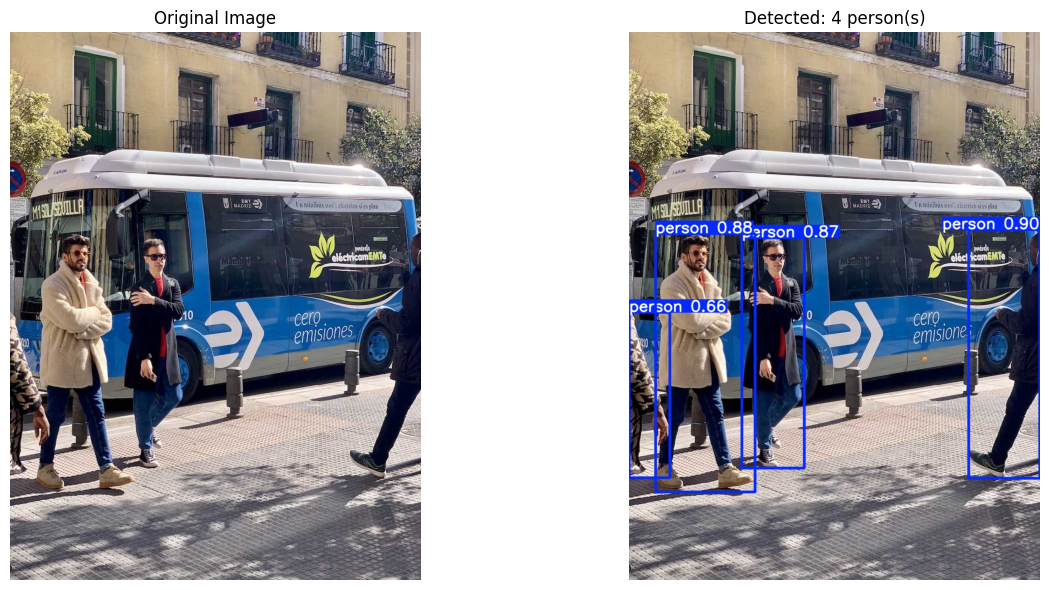

In [6]:
# Display original and detected images side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original image
original = cv2.imread(str(image_path))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Detected image
detected = cv2.imread(str(save_path))
detected = cv2.cvtColor(detected, cv2.COLOR_BGR2RGB)
axes[1].imshow(detected)
axes[1].set_title(f"Detected: {len(detections)} person(s)")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "comparison_bus.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. Batch Image Processing

In [7]:
def process_image_folder(folder_path, model, output_folder, conf_threshold=0.25):
    """
    Process all images in a folder and save detection results.
    
    Args:
        folder_path: Path to folder containing images
        model: YOLO model instance
        output_folder: Path to save annotated images and results
        conf_threshold: Confidence threshold
    
    Returns:
        all_results: Dictionary with all detection results
    """
    folder_path = Path(folder_path)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]
    image_files = [f for f in folder_path.iterdir() 
                   if f.suffix.lower() in image_extensions]
    
    all_results = {}
    
    print(f"Processing {len(image_files)} images...")
    for image_path in tqdm(image_files):
        save_path = output_folder / f"{image_path.stem}_detected{image_path.suffix}"
        results, detections = detect_persons(image_path, model, conf_threshold, save_path)
        
        all_results[image_path.name] = {
            "num_persons": len(detections),
            "detections": detections
        }
    
    return all_results

In [8]:
# Process all images in the data/images folder
batch_results = process_image_folder(
    folder_path=DATA_DIR / "images",
    model=model,
    output_folder=OUTPUT_DIR / "batch",
    conf_threshold=0.25
)

# Print summary
print("\nBatch Processing Summary:")
print("-" * 40)
total_persons = 0
for filename, result in batch_results.items():
    print(f"{filename}: {result['num_persons']} person(s)")
    total_persons += result['num_persons']
print("-" * 40)
print(f"Total persons detected: {total_persons}")

Processing 2 images...


100%|██████████| 2/2 [00:00<00:00, 13.28it/s]


Batch Processing Summary:
----------------------------------------
zidane.jpg: 2 person(s)
bus.jpg: 4 person(s)
----------------------------------------
Total persons detected: 6


In [9]:
# Save results to JSON
json_path = OUTPUT_DIR / "batch_results.json"
with open(json_path, 'w') as f:
    json.dump(batch_results, f, indent=2)
print(f"Results saved to {json_path}")

# Save results to CSV
csv_data = []
for filename, result in batch_results.items():
    for det in result['detections']:
        bbox = det['bbox_xyxy']
        csv_data.append({
            "filename": filename,
            "person_id": det['id'],
            "confidence": det['confidence'],
            "x1": bbox[0],
            "y1": bbox[1],
            "x2": bbox[2],
            "y2": bbox[3]
        })

df = pd.DataFrame(csv_data)
csv_path = OUTPUT_DIR / "batch_results.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")
print(f"\nDataFrame preview:")
df.head(10)

Results saved to ../outputs/detections/batch_results.json
Results saved to ../outputs/detections/batch_results.csv

DataFrame preview:


,filename,person_id,confidence,x1,y1,x2,y2
0,zidane.jpg,0,0.916786,120.687988,202.480392,1110.127808,712.775085
1,zidane.jpg,1,0.842897,737.467896,40.739746,1140.371216,708.593506
2,bus.jpg,0,0.896752,669.809448,389.381775,809.590332,879.573120
3,bus.jpg,1,0.880558,52.161274,397.697845,248.354630,906.262451
4,bus.jpg,2,0.871154,222.633926,405.969910,345.132568,859.393372
5,bus.jpg,3,0.664339,0.245435,552.034363,80.495560,878.652954


## 5. Video Detection

In [10]:
def process_video(video_path, model, output_path, conf_threshold=0.25, show_progress=True):
    """
    Process video file and save annotated output.
    
    Args:
        video_path: Path to input video
        model: YOLO model instance
        output_path: Path to save output video
        conf_threshold: Confidence threshold
        show_progress: Whether to show progress bar
    
    Returns:
        frame_results: List of detection results per frame
    """
    video_path = Path(video_path)
    output_path = Path(output_path)
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video: {video_path.name}")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    frame_results = []
    frame_iter = range(total_frames)
    if show_progress:
        frame_iter = tqdm(frame_iter, desc="Processing frames")
    
    for frame_idx in frame_iter:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run detection
        results = model.predict(
            source=frame,
            classes=[0],
            conf=conf_threshold,
            verbose=False
        )
        
        # Get annotated frame
        annotated = results[0].plot()
        
        # Count detections
        num_persons = len(results[0].boxes)
        frame_results.append({
            "frame": frame_idx,
            "num_persons": num_persons
        })
        
        # Write frame
        out.write(annotated)
    
    cap.release()
    out.release()
    
    print(f"\nOutput saved to: {output_path}")
    return frame_results

In [13]:
# Check if there's a sample video, otherwise create a simple test
video_dir = DATA_DIR / "videos"
video_dir.mkdir(parents=True, exist_ok=True)

# List available videos
video_extensions = [".mp4", ".avi", ".mov", ".mkv"]
videos = [f for f in video_dir.iterdir() if f.suffix.lower() in video_extensions]

if videos:
    print(f"Found {len(videos)} video(s):")
    for v in videos:
        print(f"  - {v.name}")
else:
    print("No videos found in data/videos/")
    print("Please add a video file to test video detection.")
    print("\nYou can download a sample video using:")
    print('  !wget -O ../data/videos/sample.mp4 "YOUR_VIDEO_URL"')

Found 1 video(s):
  - Bangkok.mp4


Video: Bangkok.mp4
  Resolution: 1280x720
  FPS: 25
  Total frames: 650


Processing frames: 100%|██████████| 650/650 [00:36<00:00, 17.63it/s]



Output saved to: ../outputs/detections/Bangkok_detected.mp4


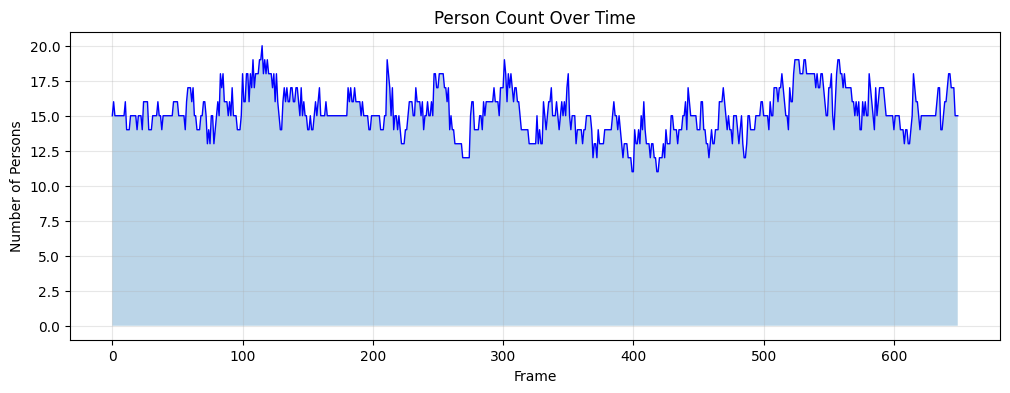


Statistics:
  Min persons: 11
  Max persons: 20
  Average: 15.24


In [14]:
# Process video if available
if videos:
    video_path = videos[0]
    output_path = OUTPUT_DIR / f"{video_path.stem}_detected.mp4"
    
    frame_results = process_video(
        video_path=video_path,
        model=model,
        output_path=output_path,
        conf_threshold=0.25
    )
    
    # Plot detection counts over time
    frames = [r['frame'] for r in frame_results]
    counts = [r['num_persons'] for r in frame_results]
    
    plt.figure(figsize=(12, 4))
    plt.plot(frames, counts, 'b-', linewidth=1)
    plt.fill_between(frames, counts, alpha=0.3)
    plt.xlabel('Frame')
    plt.ylabel('Number of Persons')
    plt.title('Person Count Over Time')
    plt.grid(True, alpha=0.3)
    plt.savefig(OUTPUT_DIR / "video_detection_plot.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nStatistics:")
    print(f"  Min persons: {min(counts)}")
    print(f"  Max persons: {max(counts)}")
    print(f"  Average: {np.mean(counts):.2f}")
else:
    print("Skipping video processing - no videos available")

## 6. Results Analysis

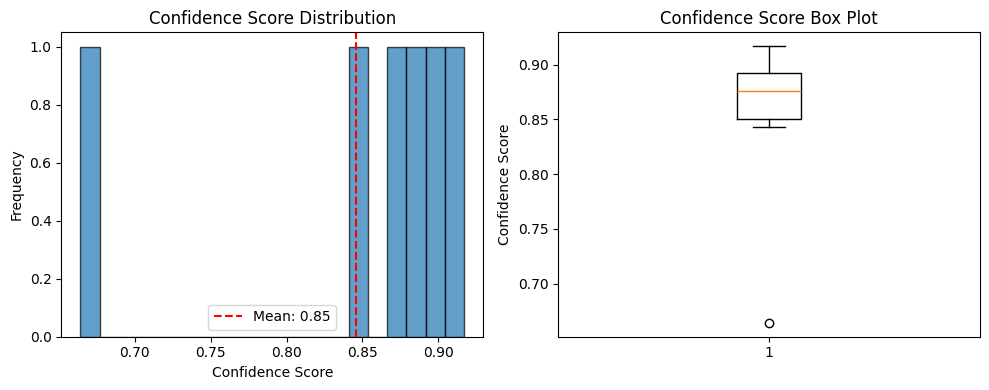

Confidence Statistics:
  Min: 0.664
  Max: 0.917
  Mean: 0.845
  Std: 0.084


In [15]:
# Analyze confidence score distribution from batch results
confidences = []
for result in batch_results.values():
    for det in result['detections']:
        confidences.append(det['confidence'])

if confidences:
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution')
    plt.axvline(np.mean(confidences), color='r', linestyle='--', label=f'Mean: {np.mean(confidences):.2f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(confidences)
    plt.ylabel('Confidence Score')
    plt.title('Confidence Score Box Plot')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "confidence_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Confidence Statistics:")
    print(f"  Min: {min(confidences):.3f}")
    print(f"  Max: {max(confidences):.3f}")
    print(f"  Mean: {np.mean(confidences):.3f}")
    print(f"  Std: {np.std(confidences):.3f}")
else:
    print("No detections to analyze")

## 7. Custom Image Detection

Use this section to test detection on your own images.

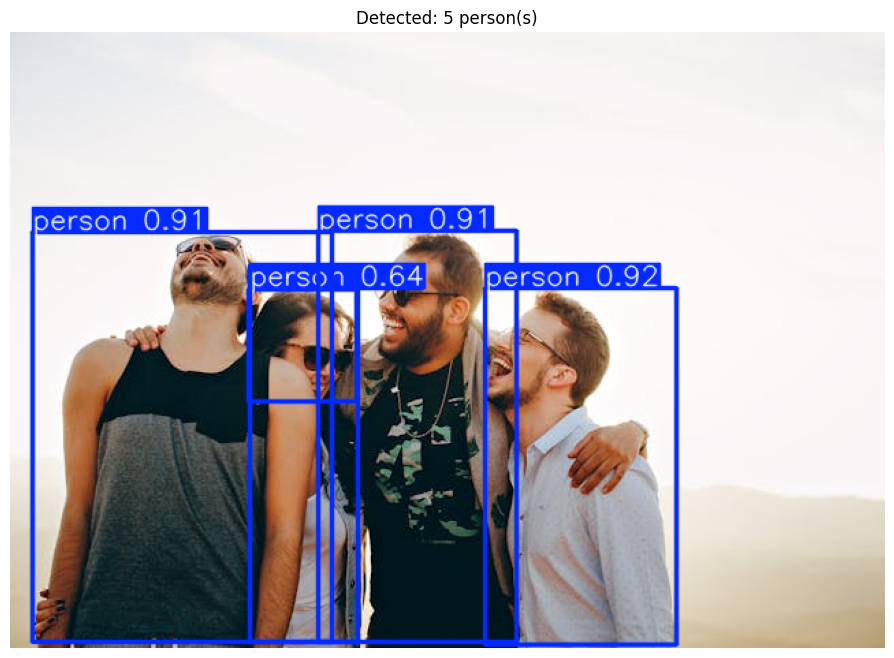

In [17]:
# Example: Detect persons in a custom image
# Uncomment and modify the path below:

custom_image = "/Users/sourangshupal/Downloads/cv-final-project/data/images/inp.jpeg"
results, detections = detect_persons(custom_image, model)

# Display result
annotated = results[0].plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(annotated_rgb)
plt.title(f"Detected: {len(detections)} person(s)")
plt.axis('off')
plt.show()

## Summary

This notebook demonstrated:
1. **Model Loading**: Using YOLO11s for person detection
2. **Single Image Detection**: Detecting persons with bounding boxes
3. **Batch Processing**: Processing multiple images with results export
4. **Video Detection**: Frame-by-frame person detection in videos
5. **Results Analysis**: Confidence score distribution analysis

**Next Steps:**
- Try `02_instance_segmentation.ipynb` for pixel-level person boundaries
- Try `03_person_counting.ipynb` for counting and crowd analysis